# Multi-objective Robust Optimization (MORO)


This exercise demostrates the application of MORO on the lake model. In contrast to the exercises in previous weeks, we will be using a slightly more sophisticated version of the problem. For details see the MORDM assignment for this week.

## Setup MORO

Many objective robust optimization aims at finding decisions that are robust with respect to the various deeply uncertain factors. For this, MORO evalues each candidate decision over a set of scenarios. For each outcome of interest, the robusntess over this set is calculated. A MOEA is used to maximize the robustness. 

For this assignment, we will be using a domain criterion as our robustness metric. The table below lists the rules that you should use for each outcome of interest.

|Outcome of interest| threhsold  |
|-------------------|------------|
| Maximum pollution | $\leq$ 0.75|
| Inertia           | $\geq$ 0.6 |
| Reliability       | $\geq$ 0.99|   
| Utility           | $\geq$ 0.75|

**1) Implement a function for each outcome that takes a numpy array with results for the outcome of interest, and returns the robustness score**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist 
from dps_lake_model import lake_model
from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant, Constraint, Policy, perform_experiments, 
                           Scenario, optimize)
from ema_workbench.analysis import parcoords
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench.em_framework import sample_uncertainties
from ema_workbench.em_framework.evaluators import MC
import functools

C:\Users\Ilmo\Anaconda3\lib\site-packages\ema_workbench\em_framework\evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')


In [31]:
def max_P(data):
    return np.sum(data<=0.75)/data.shape[0]

def inertia(data):
    return np.sum(data>=0.6)/data.shape[0]

def reliability(data):
    return np.sum(data>=0.99)/data.shape[0]

def utility(data):
    return np.sum(data>=0.75)/data.shape[0]
    
SMALLER = 'SMALLER'
LARGER = 'LARGER'


**2) Generate 4 random release policies, and evaluate them over 500 scenarios. Sample the scenarios using Monte Carlo sampling. Next evaulate your robustness function for 1, 2, 3, ... 500 scenarios for each outcome and visualize this. What can you tell about the convergernce of the robusntess metric as a function of the number of scenarios?**

In [4]:
from dps_lake_model import lake_model

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_model)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

lake_model.levers = [RealParameter("c1", 0, 1),
                     RealParameter("c2", 0, 1),
                     RealParameter("r1", 0, 1),
                     RealParameter("r2", 0, 1),
                     RealParameter("w1", 0, 1)]

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

lake_model.constantcs = [Constant('alpha', 0.41),
                        Constant('reps', 150)],

convergence_metrics = [HyperVolume.from_outcomes(lake_model.outcomes),
                       EpsilonProgress()]

In [64]:
n_scenarios = 500
scenarios = sample_uncertainties(lake_model, n_scenarios)

In [6]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=500, policies=4, uncertainty_sampling='mc')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


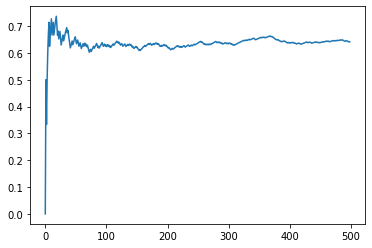

In [74]:
robust = []

def robustheid(data, function, policy):
    for i in range(n_scenarios):
        if i > 0:
            a = function(data[n_scenarios*policy:i+(n_scenarios*policy)])
            robust.append(a)
    return robust

robustheid(outcomes['max_P'], max_P, 0)
plt.plot(robust)
plt.show()

## Searching for candidate solutions
Set up the robust optimization problem using the robustness functions you have specified. Assume that you will need 50 scenarios for estimating the robustness. Use $\epsilon$-progress and hypervolume to track convergence. Solve the optimization problem. As $\epsilon$ values, you can assume 0.05 for each of the four robustness metrics.

*note: this optimization problem is computationally very expensive. Develop and test your code using a sequential evaluator, a low number of function evaluations (e.g., 200), and a low number of scenarios (e.g., 5). Once everything seems to be working replace the sequential evaluator with an multiprocessing or ipyparallel evaluator, and increase the number of nfe and scenarios*.


In [80]:
n_scenarios = 50
nfe = 1000

scenarios = sample_uncertainties(lake_model, n_scenarios)

robustness_functions=[ScalarOutcome('robust max_P', kind=ScalarOutcome.MINIMIZE, variable_name='max_P', function=max_P),
                     ScalarOutcome('robust utility', kind=ScalarOutcome.MAXIMIZE, variable_name='utility', function=utility),
                     ScalarOutcome('robust inertia', kind=ScalarOutcome.MAXIMIZE, variable_name='inertia', function=inertia),
                     ScalarOutcome('robust reliability', kind=ScalarOutcome.MAXIMIZE, variable_name='reliability', function=reliability)]


In [81]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results, convergence = evaluator.robust_optimize(robustness_functions, scenarios=scenarios, nfe=nfe,
                                  epsilons=[0.05, ] * len(robustness_functions), convergence = convergence_metrics,
                                  population_size=5)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 28/1000 nfe
[MainProcess/INFO] generation 10: 58/1000 nfe
[MainProcess/INFO] generation 15: 88/1000 nfe
[MainProcess/INFO] generation 20: 118/1000 nfe
[MainProcess/INFO] generation 25: 148/1000 nfe
[MainProcess/INFO] generation 30: 178/1000 nfe
[MainProcess/INFO] generation 35: 208/1000 nfe
[MainProcess/INFO] generation 40: 238/1000 nfe
[MainProcess/INFO] generation 45: 267/1000 nfe
[MainProcess/INFO] generation 50: 297/1000 nfe
[MainProcess/INFO] generation 55: 327/1000 nfe
[MainProcess/INFO] generation 60: 357/1000 nfe
[MainProcess/INFO] generation 65: 387/1000 nfe
[MainProcess/INFO] generation 70: 416/1000 nfe
[MainProcess/INFO] generation 75: 446/1000 nfe
[MainProcess/INFO] generation 80: 476/1000 nfe
[MainProcess/INFO] generation 85: 506/1000 nfe
[MainProcess/INFO] generation 90: 535/1000 nfe
[MainProcess/INFO] generation 95: 565/1000 nfe
[MainProcess/INFO] generation 100: 

In [86]:
results

,c1,c2,r1,r2,w1,robust max_P,robust utility,robust inertia,robust reliability
0,0.281666,0.808249,0.177517,0.318285,0.385582,0.08,0.72,1.00,0.08
1,0.329073,0.506672,0.701626,0.018990,0.181311,0.12,0.72,1.00,0.12
2,0.632457,0.459346,0.051995,0.469942,0.010945,0.22,0.66,1.00,0.22
3,0.148692,0.513997,0.622971,0.453142,0.062761,0.54,0.42,1.00,0.54
4,0.355415,0.617210,0.211941,0.705016,0.822550,0.66,0.26,0.88,0.66
5,0.295194,0.389975,0.231395,0.527903,0.492470,0.76,0.16,1.00,0.76
6,0.407631,0.492595,0.119352,0.703799,0.580051,0.60,0.40,0.80,0.56
7,0.312357,0.594033,0.684876,0.496602,0.601254,0.48,0.44,1.00,0.48
8,0.407631,0.492595,0.119352,0.707487,0.221970,0.62,0.38,0.82,0.62
9,0.590317,0.397768,0.532818,0.623062,0.174899,0.64,0.24,1.00,0.64


**Plot your $\epsilon$-progress to evaluate convergergence, and visualize the trade-offs using parallel coordinate plots**

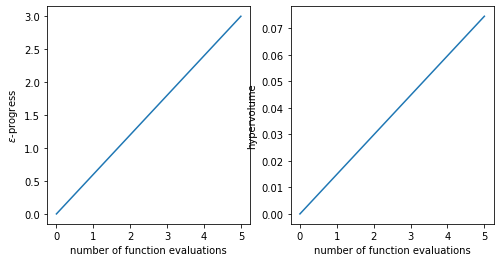

In [83]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

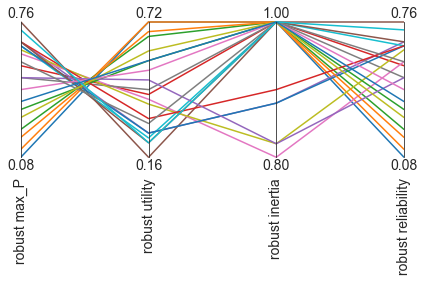

In [88]:
from ema_workbench.analysis import parcoords
import matplotlib.pyplot as plt

results2 = results.drop(['c1', 'c2', 'r1', 'r2', 'w1'], axis =1)
limits = pd.DataFrame({'robust max_P':[results2['robust max_P'].min(),results2['robust max_P'].max()],
                      'robust utility':[results2['robust utility'].min(),results2['robust utility'].max()],
                      'robust inertia':[results2['robust inertia'].min(),results2['robust inertia'].max()],
                      'robust reliability':[results2['robust reliability'].min(),results2['robust reliability'].max()]})
axes = parcoords.ParallelAxes(limits)
axes.plot(results2)
 
plt.show()

**What does this plot tell us about the tradeoffs and conflicting objectives?**

## Re-evaluate candidate solutions under uncertainty

We have used only 50 scenarios for the optimization. Take the results and re-evaluate them over a larger set (assume 1000 scenarios). How different are your results? What does this imply for the assumption of 50 scenarios during robust optimization.

*hint: use the to_dict method on a dataframe, next generate Policy objects in a list expression by iterating over the dicts returned by the to_dict method*

In [89]:
from ema_workbench import Policy

df_policies = results.drop(columns = ['robust max_P', 'robust utility', 'robust reliability', 'robust inertia'])
p_dict = df_policies.T.to_dict()

policylist = []
for key,values in p_dict.items():
    policylist.append(Policy('%d' % key, **values))

In [90]:
ema_logging.log_to_stderr(ema_logging.INFO)
n_scenarios = 1000

with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments2, outcomes2 = evaluator.perform_experiments(scenarios=n_scenarios, policies = policylist)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 21 policies * 1 model(s) = 21000 experiments
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 4200 cases completed
[MainProcess/INFO] 6300 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 10500 cases completed
[MainProcess/INFO] 12600 cases completed
[MainProcess/INFO] 14700 cases completed
[MainProcess/INFO] 16800 cases completed
[MainProcess/INFO] 18900 cases completed
[MainProcess/INFO] 21000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [124]:
df_robust=pd.DataFrame()
df_robust = results.assign(extr_max_P = "", extr_utility = "", extr_inertia = "", extr_reliability = "")

def robusttest():
    for i in range(len(policylist)):
        for j in outcomes2.keys():
            if j == 'max_P':
                a = max_P(outcomes2[j][i*1000:(i+1)*1000])
                df_robust.loc[i, 'extr_max_P'] = a
            elif j == 'utility':
                a = utility(outcomes2[j][i*1000:(i+1)*1000])
                df_robust.loc[i, 'extr_utility'] = a
            elif j == 'reliability':
                a = reliability(outcomes2[j][i*1000:(i+1)*1000])
                df_robust.loc[i, 'extr_reliability'] = a
            elif j == 'inertia':
                a = inertia(outcomes2[j][i*1000:(i+1)*1000])
                df_robust.loc[i, 'extr_inertia'] = a

    return df_robust

robusttest()

,c1,c2,r1,r2,w1,robust max_P,robust utility,robust inertia,robust reliability,extr_max_P,extr_utility,extr_inertia,extr_reliability
0,0.281666,0.808249,0.177517,0.318285,0.385582,0.08,0.72,1.00,0.08,0.1,0.719,1,0.098
1,0.329073,0.506672,0.701626,0.018990,0.181311,0.12,0.72,1.00,0.12,0.137,0.707,1,0.131
2,0.632457,0.459346,0.051995,0.469942,0.010945,0.22,0.66,1.00,0.22,0.295,0.654,1,0.293
3,0.148692,0.513997,0.622971,0.453142,0.062761,0.54,0.42,1.00,0.54,0.543,0.465,1,0.543
4,0.355415,0.617210,0.211941,0.705016,0.822550,0.66,0.26,0.88,0.66,0.615,0.394,0.893,0.613
5,0.295194,0.389975,0.231395,0.527903,0.492470,0.76,0.16,1.00,0.76,0.648,0.269,0.999,0.643
6,0.407631,0.492595,0.119352,0.703799,0.580051,0.60,0.40,0.80,0.56,0.576,0.487,0.753,0.574
7,0.312357,0.594033,0.684876,0.496602,0.601254,0.48,0.44,1.00,0.48,0.512,0.483,1,0.51
8,0.407631,0.492595,0.119352,0.707487,0.221970,0.62,0.38,0.82,0.62,0.589,0.457,0.803,0.586
9,0.590317,0.397768,0.532818,0.623062,0.174899,0.64,0.24,1.00,0.64,0.594,0.349,1,0.593


In [130]:
difference = []

for i in range(len(df_robust)):
    a = abs(df_robust.loc[i, 'robust max_P'] - df_robust.loc[i, 'extr_max_P'])
    difference.append(a)

print(difference)

[0.020000000000000004, 0.017000000000000015, 0.07499999999999998, 0.0030000000000000027, 0.04500000000000004, 0.11199999999999999, 0.02400000000000002, 0.03200000000000003, 0.031000000000000028, 0.04600000000000004, 0.03400000000000003, 0.055999999999999994, 0.05099999999999999, 0.06300000000000006, 0.04800000000000004, 0.05600000000000005, 0.056999999999999995, 0.0119999999999999, 0.012999999999999956, 0.07999999999999996, 0.07500000000000001]


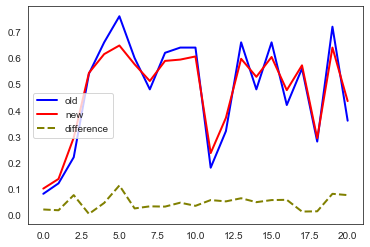

In [140]:
plt.plot(df_robust['robust max_P'], markersize=12, color='blue', linewidth=2, label = 'old')
plt.plot(df_robust['extr_max_P'], marker='', color='red', linewidth=2, label = 'new')
plt.plot(difference, color='olive', linewidth=2, linestyle='dashed', label="difference")
plt.legend()

## Comparison
If you have time, import your solutions found for MORDM and re-evaluate them over the same set of scnearios as used for re-evaluating the MORO results. Compare the robustness of MORDM and MORO, what do you observe?